# **Household Electric Power Consumption - Confidence lab**

In this part of the lab we'll look into getting confidence or in this case confidence intervals.

## Load Data

In [ ]:
# get the dataset

# !wget "https://raw.githubusercontent.com/sunnypwang/mwa_workshop/master/lab2/122_260_bundle_archive.zip" 
!curl -O "https://raw.githubusercontent.com/sunnypwang/mwa_workshop/master/lab2/122_260_bundle_archive.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 19.4M    0 16384    0     0  16384      0  0:20:42 --:--:--  0:20:42 24380
100 19.4M  100 19.4M    0     0  19.4M      0  0:00:01  0:00:01 --:--:-- 14.1M


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
df = pd.read_csv('122_260_bundle_archive.zip', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# filling nan with mean in any columns
for j in range(0,7):        
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [ ]:
df_resample = df.resample('D').sum()[1:]
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-17,3390.46000,226.006000,345725.320000,14398.600000,2033.000000,4187.00000,13341.000000
2006-12-18,2203.82600,161.792000,347373.640000,9247.200000,1063.000000,2621.00000,14018.000000
2006-12-19,1666.19400,150.942000,348479.010000,7094.000000,839.000000,7602.00000,6197.000000
2006-12-20,2225.74800,160.998000,348923.610000,9313.000000,0.000000,2648.00000,14063.000000
2006-12-21,1718.80723,144.413429,347097.989716,7247.855519,1767.243847,2625.59704,10433.916895


### Feature Engineering

In [ ]:
def series_to_supervised(dff, n_in=1, n_out=1, dropnan=True):
	# n_vars = 1 if type(data) is list else data.shape[1]
	n_vars = dff.shape[1]
	# dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in-1, 0, -1):
		cols.append(dff.shift(i))
		names += [f'{dff.columns[j]}(t-{i})' for j in range(len(dff.columns))]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out+1):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [f'{dff.columns[j]}(t)' for j in range(len(dff.columns))]
		else:
			names += [f'{dff.columns[j]}(t+{i})' for j in range(len(dff.columns))]
	# put it all together
	
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
from datetime import timedelta
# frame as supervised learning
n_day_feat = 5
n_day_pred = 1


df_resample_add_feats = series_to_supervised(df_resample, n_day_feat, n_day_pred)

# We are going to use data of the previous days to predict the current power consumption (Global_active_power)

# First, we drop all today's features that we don't want to predict
today_feats_dropped = [f"{col}(t+1)" for col in df_resample.columns if col != "Global_active_power"]
df_clean = df_resample_add_feats.drop(columns=today_feats_dropped)

# Next, we drop all unncessary features of previous days
prevday_feats_dropped = []
for col in ["Global_active_power", "Global_reactive_power", "Global_intensity", "Voltage"]:
  for d in range(1,n_day_feat):
    prevday_feats_dropped.append( f"{col}(t-{d})")

for col in ["Global_active_power", "Global_reactive_power", "Global_intensity", "Voltage"]:
    prevday_feats_dropped.append( f"{col}(t)")

df_clean = df_clean.drop(columns=prevday_feats_dropped)

# Then, we add categorical features such as day of week and month 
# 1 is Monday, 7 is Sunday
day_of_week = pd.get_dummies(df_clean.index.map(lambda x: (x + timedelta(days=1)).isoweekday()), prefix='day(t+1)')
day_of_week.index = df_clean.index
month = pd.get_dummies(df_clean.index.map(lambda x: (x + timedelta(days=1)).month), prefix='month(t+1)')
month.index = df_clean.index

# In total, we have
df_clean = pd.concat([df_clean, day_of_week, month], axis=1)
df_clean.head()

,Sub_metering_1(t-4),Sub_metering_2(t-4),Sub_metering_3(t-4),Sub_metering_1(t-3),Sub_metering_2(t-3),Sub_metering_3(t-3),Sub_metering_1(t-2),Sub_metering_2(t-2),Sub_metering_3(t-2),Sub_metering_1(t-1),...,month(t+1)_3,month(t+1)_4,month(t+1)_5,month(t+1)_6,month(t+1)_7,month(t+1)_8,month(t+1)_9,month(t+1)_10,month(t+1)_11,month(t+1)_12
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-21,2033.000000,4187.00000,13341.000000,1063.000000,2621.00000,14018.000000,839.000000,7602.00000,6197.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
2006-12-22,1063.000000,2621.00000,14018.000000,839.000000,7602.00000,6197.000000,0.000000,2648.00000,14063.000000,1767.243847,...,0,0,0,0,0,0,0,0,0,1
2006-12-23,839.000000,7602.00000,6197.000000,0.000000,2648.00000,14063.000000,1767.243847,2625.59704,10433.916895,3151.000000,...,0,0,0,0,0,0,0,0,0,1
2006-12-24,0.000000,2648.00000,14063.000000,1767.243847,2625.59704,10433.916895,3151.000000,350.00000,11131.000000,2669.000000,...,0,0,0,0,0,0,0,0,0,1
2006-12-25,1767.243847,2625.59704,10433.916895,3151.000000,350.00000,11131.000000,2669.000000,425.00000,14726.000000,1703.000000,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_clean.columns

Index(['Sub_metering_1(t-4)', 'Sub_metering_2(t-4)', 'Sub_metering_3(t-4)',
       'Sub_metering_1(t-3)', 'Sub_metering_2(t-3)', 'Sub_metering_3(t-3)',
       'Sub_metering_1(t-2)', 'Sub_metering_2(t-2)', 'Sub_metering_3(t-2)',
       'Sub_metering_1(t-1)', 'Sub_metering_2(t-1)', 'Sub_metering_3(t-1)',
       'Sub_metering_1(t)', 'Sub_metering_2(t)', 'Sub_metering_3(t)',
       'Global_active_power(t+1)', 'day(t+1)_1', 'day(t+1)_2', 'day(t+1)_3',
       'day(t+1)_4', 'day(t+1)_5', 'day(t+1)_6', 'day(t+1)_7', 'month(t+1)_1',
       'month(t+1)_2', 'month(t+1)_3', 'month(t+1)_4', 'month(t+1)_5',
       'month(t+1)_6', 'month(t+1)_7', 'month(t+1)_8', 'month(t+1)_9',
       'month(t+1)_10', 'month(t+1)_11', 'month(t+1)_12'],
      dtype='object')

In [ ]:
# features - labels separation

# We will use next day's day of week and month as features as well
lab_idx = list(df_clean.columns).index('Global_active_power(t+1)')

cont_features = df_clean.values[:,:lab_idx]
cat_features = df_clean.values[:, lab_idx+1:]
labels = df_clean.values[:, lab_idx:lab_idx+1]

print(cont_features.shape, cat_features.shape, labels.shape)

(1436, 15) (1436, 19) (1436, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler # for normalization

# use first three years as training
n_train_time = 365*3

# split into input and outputs
train_X_cont, train_X_cat , train_y_unscaled = cont_features[:n_train_time], cat_features[:n_train_time], labels[:n_train_time]
test_X_cont, test_X_cat, test_y_unscaled = cont_features[n_train_time:], cat_features[n_train_time:], labels[n_train_time:]

In [ ]:
# Scale continuous data
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_X_cont_scaled = X_scaler.fit_transform(train_X_cont)
test_X_cont_scaled = X_scaler.transform(test_X_cont)

train_y = y_scaler.fit_transform(train_y_unscaled).ravel()
test_y =  y_scaler.transform(test_y_unscaled).ravel()

# After scaling continuous features, we will combine them with categorical features
train_X = np.concatenate((train_X_cont_scaled, train_X_cat), axis=1)
test_X = np.concatenate((test_X_cont_scaled, test_X_cat), axis=1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1095, 34) (1095,) (341, 34) (341,)


In [ ]:
# example of training data
train_X[0]

array([0.18185686, 0.34577587, 0.66148949, 0.09508797, 0.21645057,
       0.69864442, 0.07505062, 0.62779751, 0.26941441, 0.        ,
       0.21868032, 0.7011141 , 0.15808432, 0.21683021, 0.50194374,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        ])

In [ ]:
train_y[0]

0.4623036297326075

#### Getting the interval

In the following section, we will train and predict a model with multiple iterations to compute a prediction interval.

In order to do so, we will define a function that will receive a prediction matrix `pred_matrix` and an interval range `p`. 

`pred_matrix` is a 2D matrix of size `(M,N)` where `M` is the number of iterations and `N` is the number of days in the test set. 

`p` is an interval range, which is between 0 and 1.

This function returns the followings:

* mean across each prediction iterations with size `N`
* standard deviation across each prediction iterations with size `N`
* z-score corresponding to `p` value. Note that we only one side of z
* interval value, which is defined as `standard deviation * z-score` 

Your job is to compute these values





In [ ]:
import scipy.stats

def find_mean_std_interval(pred_matrix, p=0.95):
    ##############################
    ## Compute mean, standard deviation of a prediction matrix 
    ## and find the z-score and a one-sided interval
    ##############################

    mean = np.mean(pred_matrix, axis = 0)
    std = np.std(pred_matrix, axis = 0)
    cdfval = 0.5 + p/2
    z = scipy.stats.norm.ppf(cdfval) # unit gaussian
    interval = z*std
    
    return mean, std, z, interval

In [ ]:
def plot_prediction_interval(yhat_matrix, p=0.95, truth=True):
    assert len(yhat_matrix.shape) > 1

    mean, std, z, interval = find_mean_std_interval(yhat_matrix, p)

    plt.figure(figsize=(20,5))
    plt.plot(mean, c='r', lw=0.9, label='pred')
    if truth:
        plt.plot(test_y_unscaled, c='C1', lw=0.8, label='truth')
    plt.fill_between(np.arange(len(mean)), mean+interval, mean-interval, color='C2', alpha=0.3)
    plt.ylabel('Global_active_power(t+1)')
    plt.xlabel('day')
    plt.title('{}% prediction interval'.format(np.around(100*p)))
    plt.grid('on')
    plt.legend()
    plt.show()

def calculate_prob(y, low, up):
    c = np.count_nonzero(np.logical_and(y < up, y > low))
    print('Probability that truth is in interval = {:.2f}%'.format(100*c/len(y)))

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE :',mae)
    return mae
mae = {}

### Select Interval
<a id="#interval"></a>

In [ ]:
p = 0.95 #@param {type:"number"}

## XGBoost Regression Tree

We will train XGBoost regression trees 100 times, each with randomly selected subset of data.

[XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [ ]:
from xgboost import XGBRegressor
y_pred_xgb = []
for i in range(100):
    xgbreg = XGBRegressor(
                    learning_rate=0.3,
                    max_depth=4,
                    min_child_weight=1,
                    n_estimators=50,  
                    gamma=0.2,   
                    reg_lambda=0.1,
                    colsample_bytree=0.1,
                    objective='reg:squarederror',
                    seed=i
                    )
    pred = xgbreg.fit(train_X,train_y).predict(test_X)
    y_pred_xgb.append(pred)
    # print(pred[0])
y_pred_xgb = np.array(y_pred_xgb)
y_pred_xgb_inv = y_scaler.inverse_transform(y_pred_xgb)

### Evaluation

Then, we will plot the prediction interval by finding mean and standard deviation across all predictions.

We also report Mean Absolute Error (MAE) of the prediction mean

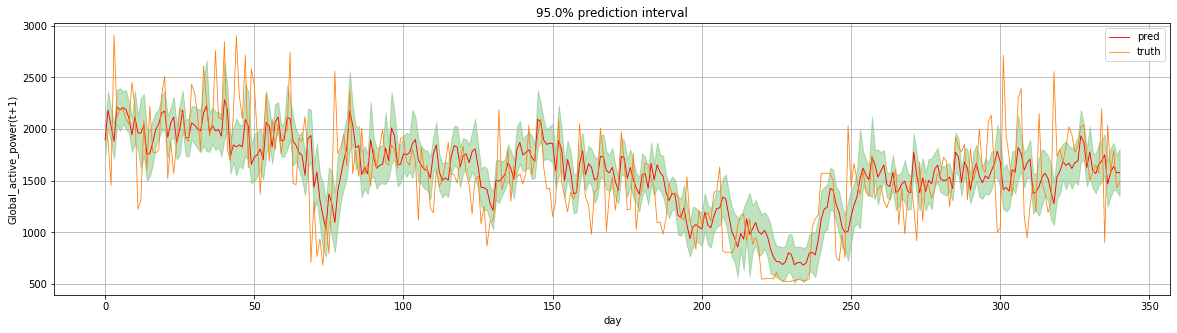

MAE : 266.98540552403955


In [ ]:
plot_prediction_interval(y_pred_xgb_inv, truth=True)
mae['xgb'] = evaluate(test_y_unscaled, y_pred_xgb_inv.mean(axis=0))

## Neural Networks

### Monte Carlo Dropout

We will calculate uncertainty estimates for neural network models using Monte Carlo Dropout (Dropout at test time)

Normally, dropout is only active at training time, where it serves as a regularization to avoid overfitting. During test time, dropout is not applied; instead, all nodes/connections are present, but the weights are adjusted accordingly(e.g. multiply the dropout ratio). Such a model during test time can be understood as a average of an ensemble of neural networks.

Notice that for normal dropout, at test time the prediction is deterministic. Without other source of randomness, given one test data point, the model will always predict the same label or value.

For Monte Carlo dropout, the dropout is applied at both training and test time. At test time, the prediction is no longer deterministic, but depending on which nodes/links you randomly choose to keep. Therefore, given a same datapoint, your model could predict different values each time.

So the primary goal of Monte Carlo dropout is to generate random predictions and interpret them as samples from a probabilistic distribution. In the authors' words, they call it Bayesian interpretation.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
tf.__version__

'2.1.0'

In [ ]:
def get_nn(inp_shape, drop_rate=0.2, summary=True, drop_on_test=None):
    inp = Input((inp_shape,))
    x = Dense(50, activation='relu')(inp)
    x = Dropout(drop_rate)(x, training=drop_on_test)
    x = Dense(50, activation='relu')(x)
    x = Dropout(drop_rate)(x, training=drop_on_test)
    x = Dense(50, activation='relu')(x)
#     x = Dropout(drop_rate)(x, training=drop_on_test)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mae')
    if summary:
        model.summary()
    return model

tf.keras.backend.clear_session()
nn = get_nn(train_X.shape[1], drop_on_test=True) # Monte Carlo Dropout

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                1750      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51    

This time, we will employ another callbacks, called "ModelCheckpoint".

ModelCheckpoint allows us to save model weights periodically during training, allowing us to save the best-performing weights before the model overfits for later evaluation.

In this lab, we will save the weight after every epoch, and only if the weight has better validation loss will it be overwritten.

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Initialize callbacks
callbacks = [LearningRateScheduler(ExponentialDecay(
                                    initial_learning_rate=0.01,
                                    decay_steps=n_train_time*20//32,
                                    decay_rate=0.96,
                                    staircase=False)), 
             ModelCheckpoint(filepath='weight.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True)]

In [ ]:
# verbose controls log message during training
    # verbose = 0 prints nothing
    # verbose = 1 prints progress bar
    # verbose = 2 prints summary at each epoch
verbose = 0

In [ ]:
epochs = 50
batch_size = 32
hists = nn.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=True, callbacks=callbacks)

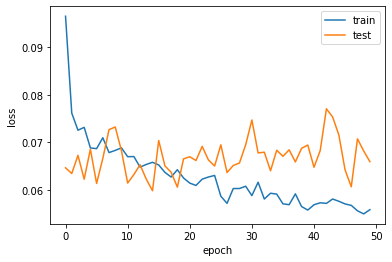

In [ ]:
# summarize history for loss
plot_step = 1
plt.plot(hists.history['loss'][::plot_step])
plt.plot(hists.history['val_loss'][::plot_step])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Let's load our best weight back using `load_weights`

In [ ]:
nn.load_weights('weight.h5')

### Evaluation

Then, we will plot the prediction interval by finding mean and standard deviation across all predictions.

We also report Mean Absolute Error (MAE) of the prediction mean

In [ ]:
y_pred_nn = []
for i in range(100):
    y_pred_nn.append(nn.predict(test_X).ravel())
y_pred_nn = np.array(y_pred_nn)
y_pred_nn_inv = y_scaler.inverse_transform(y_pred_nn)

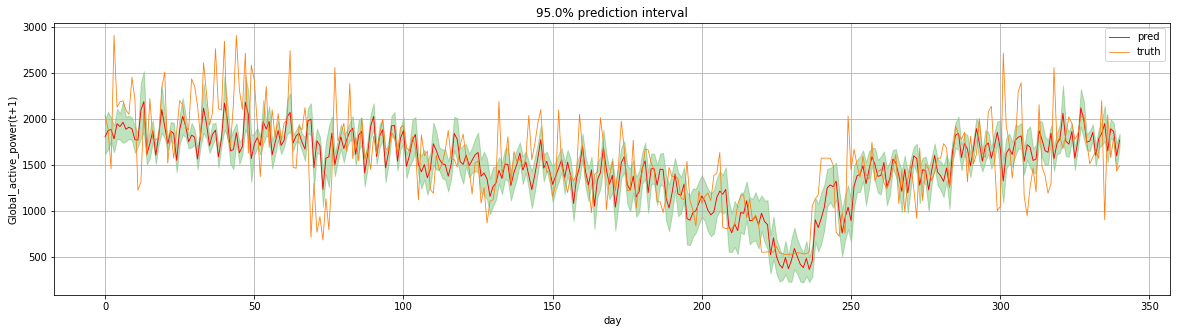

MAE : 262.4289847904706


In [ ]:
plot_prediction_interval(y_pred_nn_inv)
mae['nn'] = evaluate(test_y_unscaled, y_pred_nn_inv.mean(axis=0))

Let's compare MAE with full feed-forward network with no dropout. Which one is better?

In [ ]:
nn_full = get_nn(train_X.shape[1], summary=False, drop_on_test=None) # No Dropout on test time
nn_full.load_weights('weight.h5')
y_pred_nn_full = nn_full.predict(test_X).ravel()
y_pred_nn_full_inv = y_scaler.inverse_transform(y_pred_nn_full.reshape(-1,1))
mae['nn_full'] = evaluate(test_y_unscaled, y_pred_nn_full_inv)

MAE : 260.1299386362081


## Changing the interval value

So far, we use 95% interval when evaluating. In reality, we can adjust this interval depends on our confidence level we want.

You can try changing the interval value yourself and see how the plot changes (Jump to **Select Interval**)

For example, the plot below shows the effect of various interval value for the neural network model.

Note the the relationship between the size of the interval and the value

[Click here](https://raw.githubusercontent.com/sunnypwang/mwa_workshop/master/lab3/pred_interval.png) to see full resolution

![Prediction Interval](https://raw.githubusercontent.com/sunnypwang/mwa_workshop/master/lab3/pred_interval.png)


## Extra : XGBoostQuantile

Quantile regression is an extension of linear regression used when the conditions of linear regression are not met.

While the method of least squares estimates the conditional **mean** of the response variable, quantile regression estimates the conditional **median** (or other quantile $\tau$) of the response variable.

For example, quantile regression at $\tau = 0.9$ will fit a line that makes 10% of the data above and 90% below the line.

![quantile](https://www.aptech.com/wp-content/uploads/2019/01/quantile_regression_percent_below.png)

In this section we will perform a quantile regression using XGBoost regressor

Read more about XGBoost Quantile Regression

https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b

In [ ]:
#@title XGBQuantile Class
from functools import partial
class XGBQuantile(XGBRegressor):
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )
    return np.array(split_gain)

In [ ]:
#@title Select Interval
alpha = 0.95 #@param {type:"number"}

In [ ]:
# regressor = XGBRegressor(
#     learning_rate=0.28,
#                     max_depth=8,
#                     min_child_weight=9.84,
#                     n_estimators=47,  
#                     gamma=0.23,   
#                     reg_lambda=0.1,
#                     colsample_bytree=0.01,
#                     objective='reg:squarederror',
#                     seed=1)
regressor = XGBRegressor(
                 learning_rate=0.07,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=64,                                                                    
                 reg_lambda=0.01,
                 seed=1
                 )
y_pred = regressor.fit(train_X,train_y).predict(test_X)
y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()

# regressor = XGBQuantile(
#     learning_rate=0.28,
#                     max_depth=8,
#                     min_child_weight=9.84,
#                     n_estimators=47,  
#                     gamma=0.23,   
#                     reg_lambda=0.1,
#                     colsample_bytree=0.01,
#                     objective='reg:squarederror',
#                     seed=1)  
regressor = XGBQuantile(
                 learning_rate=0.07,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=64,                                                                    
                 reg_lambda=0.01,
                 seed=1
                 )
regressor.set_params(quant_alpha=1-alpha,quant_delta=1.0,quant_thres=5.0,quant_var=3.2)
y_lower = regressor.fit(train_X,train_y).predict(test_X)

regressor.set_params(quant_alpha=alpha,quant_delta=1.0,quant_thres=6.0,quant_var = 4.2)
y_upper = regressor.fit(train_X,train_y).predict(test_X)

c:\users\phakawat\miniconda3\envs\workshop\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


[13:26:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { quant_alpha, quant_delta, quant_thres, quant_var, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { quant_alpha, quant_delta, quant_thres, quant_var, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
def plot_prediction_interval2(y_pred, y_upper, y_lower, alpha, truth=True):
    plt.figure(figsize=(20,5))
    plt.plot(y_upper, c='C0', lw=0.5, ls='-.')
    plt.plot(y_pred, c='r', lw=1, label='pred')
    plt.plot(y_lower, c='C0', lw=0.5, ls='-.')
    if truth:
        plt.plot(test_y, c='C1', lw=0.8, label='truth')
    plt.fill_between(np.arange(len(y_pred)), y_upper, y_lower, color='C2', alpha=0.3)
    plt.ylabel('Global_active_power(t+1)')
    plt.xlabel('day')
    plt.title('{}% prediction interval'.format(np.around(100*(alpha))))
    plt.legend()
    plt.grid('on')
    plt.xticks(np.arange(0,len(y_pred),10),list(df_clean.index[n_train_time:n_train_time+len(y_pred):10].astype(str)),rotation=60)
    plt.show()

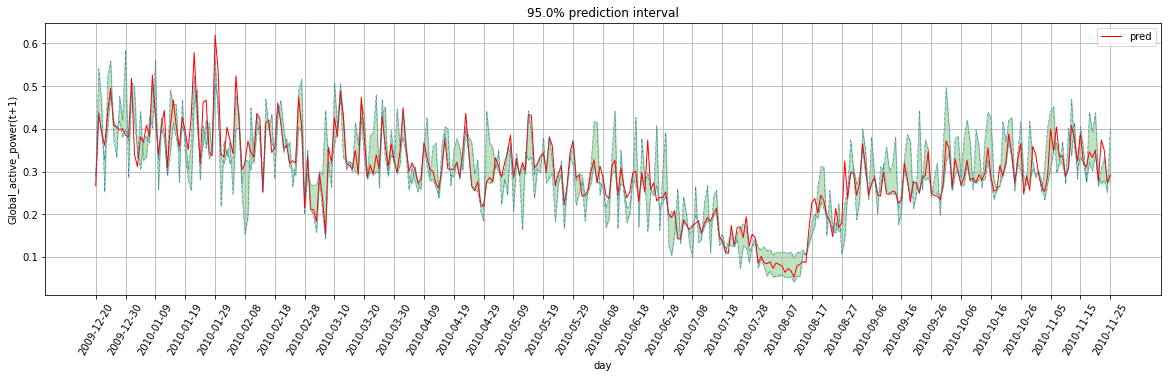

MAE : 273.1582712283826


In [ ]:
plot_prediction_interval2(y_pred, y_upper, y_lower, alpha, truth=False)
mae['xgb'] = evaluate(test_y_unscaled, y_pred_inv)